In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import os
import copy
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def conf_interval_errors(arr, up_bound=None, low_bound=None):
    # low/up bound - if <bound> then make sure mean+-1.96*sem doesn't exceed the bounds.
    mean = np.mean(arr)
    sem = np.std(arr) / np.sqrt(len(arr))  # standard error of mean
    err = 1.96 * sem
    
    if (up_bound is not None) and (mean + err > up_bound):
        up_err = up_bound - mean
    else:
        up_err = err
    
    if (low_bound is not None) and (mean - err < low_bound):
        low_err = low_bound - mean
    else:
        low_err = -err
    
    return np.abs(low_err), up_err

In [3]:
def aggregate(df, x_var):
    """
    Collect the results based on df-experiments, by a speicific variable x_var.
    """
    x_list = df[x_var].unique()
    results_per_x = {x: None for x in x_list}
    num_splits = len([f for f in os.listdir(f'experiments/movielens/exp0') if 'split' in f])
    
    for x in x_list:
        x_df = df[df[x_var] == x]
        first = True
        
        for i, r in x_df.iterrows():
            for split_num in range(num_splits):
                # load results file
                filename = f"experiments/movielens/exp{int(r['id'])}/split{split_num}/results.pkl"
                with open(filename, 'rb') as f:
                    exp_results = pickle.load(f)
                
                # collect relevant results for plots
                exp_results['references']['test']['mean_learned'] = {metric_name: np.mean(vals) 
                                                                     for metric_name, vals in exp_results['test_metrics'].items()}
                exp_results = exp_results['references']['test']
                
                if first:
                    x_results = {key: {metric_name: [] for metric_name in exp_results[key].keys()} 
                                 for key in exp_results.keys()}
                    first = False
                for method_name, metric_dct in exp_results.items():
                    for metric_name, metric_val in metric_dct.items():
                        x_results[method_name][metric_name].append(metric_val)
        results_per_x[x] = dict(x_results)
        
    return results_per_x

In [4]:
def dct_normalize(dct, min_method=None, max_method=None):
    res_dct = dict()
    for method_name, metric_dct in dct.items():
        res_dct[method_name] = {}
        for metric_name in metric_dct.keys():
            if min_method is not None and max_method is not None and metric_name != 'welfare':
                continue
            if metric_name in ['mask', '5masks', 'welfare_q025', 'welfare_q975']:
                continue
            if dct[method_name][metric_name] is None:
                continue
            
            if min_method is not None:
                res_dct[method_name][metric_name] = np.array(dct[method_name][metric_name]) - np.array(dct[min_method][metric_name])
                if max_method is not None:
                    if np.all((np.array(dct[max_method][metric_name]) - np.array(dct[min_method][metric_name])) > 0):
                        res_dct[method_name][metric_name] /= (np.array(dct[max_method][metric_name]) - np.array(dct[min_method][metric_name]))
            else:
                res_dct[method_name][metric_name] = np.array(dct[method_name][metric_name])
    return res_dct

In [5]:
def plot(base_dct, x_list, lines, line_params, metric, other_dct=None, plot_numbers=False, 
         xlabel='', ylabel='', title='', include_last=True, up_bound=None, low_bound=None, 
         ylim_extra=(0, 0.1), xticks=None, filename=None, save=False, plot_errors=True, legend=True):
    
    if not include_last:
        x_list = x_list[:-1]
    
    for line in lines:
        means = np.array([np.mean(base_dct[x][line][metric]) for x in x_list])
        errors = np.array([conf_interval_errors(base_dct[x][line][metric], up_bound=up_bound, low_bound=low_bound) 
                           for x in x_list]).T
        if not plot_errors:
            errors = np.zeros_like(errors)
            
        plt.plot(x_list, means, **line_params[line])
        plt.fill_between(x_list, 
                         means - errors[0],
                         means + errors[1],
                         alpha=0.1,
                         label='_nolegend_',
                         color=line_params[line]['color'],
                         zorder=1)
        
        if plot_numbers and line in ['welfare_opt', 'random']:
            eps_x = -0.4
            if line == 'welfare_opt':
                eps_y = 0.05 
            else:
                eps_y = -0.2 if metric == 'welfare' else -1.5
            means_other = [np.mean(other_dct[x][line][metric]) for x in x_list]
            y_loc = means + errors[1]
            for i in range(len(x_list)):
                plt.text(k_list[i] + eps_x, 
                         y_loc[i] + eps_y, 
                         f'{means_other[i]:.1f}', 
                         color=line_params[line]['color'], 
                         alpha=0.5, 
                         fontsize='small')
    
    if legend:
        plt.legend(bbox_to_anchor=(1.04, 1))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.suptitle(title)
    
    if ylim_extra is not None:
        ymin, ymax = plt.ylim()
        plt.ylim(ymin - ylim_extra[0], ymax + ylim_extra[1])
    
    if xticks is not None:
        plt.xticks(*xticks)
    
    if save:
        if filename is None:
            filename = f'{title}__{xlabel}__{ylabel}__{metric}'.replace('$', '').replace('.', '').replace('\\', '').replace('% ', '')
        plt.savefig(os.path.join('plots', f'{filename}.pdf'), format='pdf', bbox_inches='tight')

In [6]:
os.makedirs('plots', exist_ok=True)

In [7]:
import matplotlib.pylab as pl

line_params = {'welfare_opt':          dict(color='tab:grey', linestyle='--', marker='+', label='oracle'),
              'random':                dict(color='tab:blue',   linestyle='--', marker='+', label='random'), 
              'price_predictive':      dict(color='tab:green',  linestyle='-',  marker='',  label='price-pred'),
              'choice_predictive':     dict(color='tab:purple', linestyle='-',  marker='',  label='choice-pred'), 
              'best_learned':          dict(color='tab:red',    linestyle='-',  marker='',  label=r'DbR$ (\hat{\mu})$'),
              'best_weights_learned':  dict(color='tab:orange',   linestyle='-',  marker='',  label=r'DbR$ (\hat{\theta})$'),
              'mean_learned':          dict(color='tab:brown',  linestyle='-',  marker='',  label=r'DbR$ (\hat{\pi})$'),
              }

cont_colors = pl.cm.copper(np.linspace(0, 1, 5))

In [8]:
all_exp_df = pd.read_csv('all_exp.csv')

# d=12

In [9]:
df = all_exp_df[(all_exp_df['d'] == 12) & 
                (all_exp_df['gamma'] == 0.5) & 
                (all_exp_df['V_eps'] == 0.0) & 
                (all_exp_df['p_eps'] == 0.0) & 
                (all_exp_df['rho'] == 0.0)]

per_lam = {lam: aggregate(df[df['proxy_lam_name'] == lam], 'k') for lam in df['proxy_lam_name'].unique()}
lam_list = sorted(per_lam.keys())
k_list = sorted(per_lam[lam_list[0]].keys())

# normalized variations
per_lam_norm_ba = {}  # normalized below and above
per_lam_norm_b = {}   # normalized below
for lam in lam_list:
    per_lam_norm_ba[lam] = {}
    per_lam_norm_b[lam] = {}
    for k in k_list:
        per_lam_norm_ba[lam][k] = dct_normalize(per_lam[lam][k], min_method='random', max_method='welfare_opt')
        per_lam_norm_b[lam][k] = dct_normalize(per_lam[lam][k], min_method='random', max_method=None)

In [10]:
lines = ['welfare_opt', 
         'mean_learned', 'best_learned', 'best_weights_learned', 
         'choice_predictive', 'price_predictive', 
         'random'
        ]

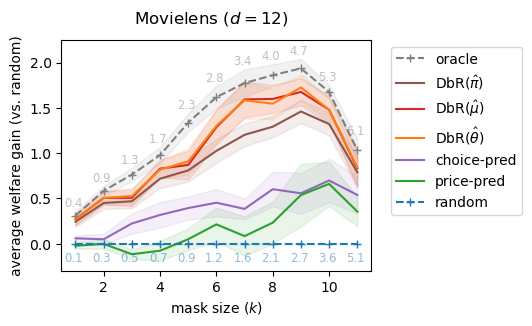

In [11]:
plt.figure(figsize=(4,3))
plot(base_dct=per_lam_norm_b['1-k/2d'], 
     x_list=k_list, 
     lines=lines,
     line_params=line_params,
     metric='welfare', 
     other_dct=per_lam['1-k/2d'], 
     plot_numbers=True, 
     xlabel=r'mask size ($k$)', 
     ylabel='average welfare gain (vs. random)', 
     title=r'Movielens ($d=12$)', 
     include_last=False,
     filename='d12_welfare_b'
    )
plt.show()

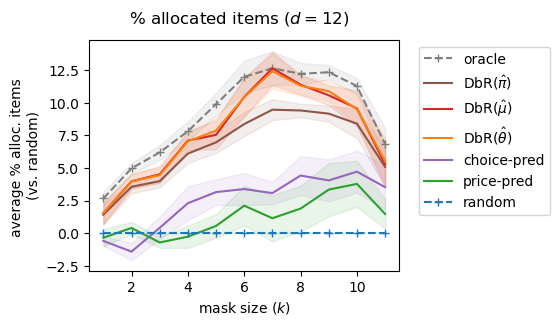

In [12]:
plt.figure(figsize=(4,3))
plot(base_dct=per_lam_norm_b['1-k/2d'], 
     x_list=k_list, 
     lines=lines,
     line_params=line_params,
     metric='unique_items', 
     xlabel=r'mask size ($k$)', 
     ylabel='average % alloc. items \n(vs. random)', 
     title='% allocated items ($d=12$)', 
     include_last=False,
    )
plt.show()

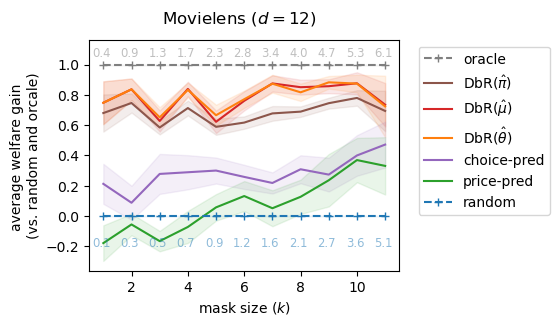

In [13]:
plt.figure(figsize=(4,3))
plot(base_dct=per_lam_norm_ba['1-k/2d'], 
     x_list=k_list, 
     lines=lines,
     line_params=line_params,
     metric='welfare', 
     other_dct=per_lam['1-k/2d'], 
     plot_numbers=True, 
     xlabel=r'mask size ($k$)', 
     ylabel='average welfare gain \n(vs. random and orcale)', 
     title=r'Movielens ($d=12$)', 
     include_last=False,
     up_bound=1, 
     low_bound=None,
    )
plt.show()

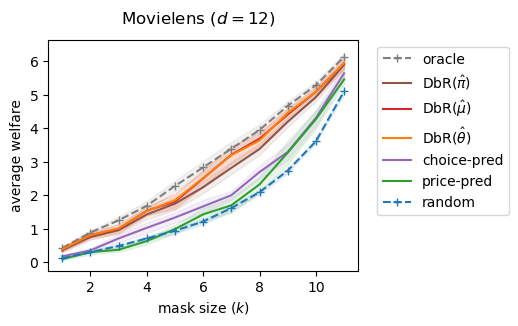

In [14]:
plt.figure(figsize=(4,3))
plot(base_dct=per_lam['1-k/2d'], 
     x_list=k_list, 
     lines=lines,
     line_params=line_params,
     metric='welfare', 
     xlabel=r'mask size ($k$)', 
     ylabel='average welfare', 
     title=r'Movielens ($d=12$)', 
     include_last=False,
    )
plt.show()

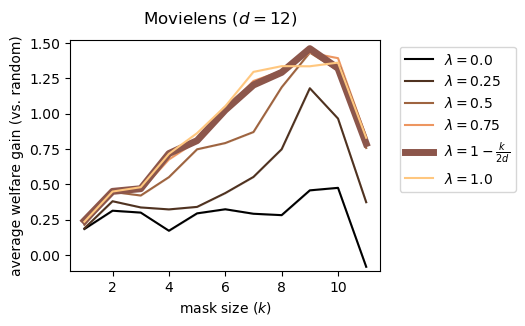

In [15]:
plt.figure(figsize=(4,3))
j = 0

for i, lam in enumerate(lam_list):
    lam_params = dict()
    if lam == '1-k/2d':
        lam_params['mean_learned'] = dict(color='tab:brown', linestyle='-', label=r'$\lambda=1-\frac{k}{2d}$', linewidth=5)
    else:
        lam_params['mean_learned'] = dict(color=cont_colors[j], linestyle='-', label=f'$\lambda={lam}$')
        j += 1
    plot(base_dct=per_lam_norm_b[lam], 
         x_list=k_list, 
         lines=['mean_learned'],
         line_params=lam_params,
         metric='welfare', 
         xlabel=r'mask size ($k$)', 
         ylabel='average welfare gain (vs. random)', 
         title=r'Movielens ($d=12$)', 
         include_last=False,
         ylim_extra=(0, 0.17),
         plot_errors=False
        )
plt.show()

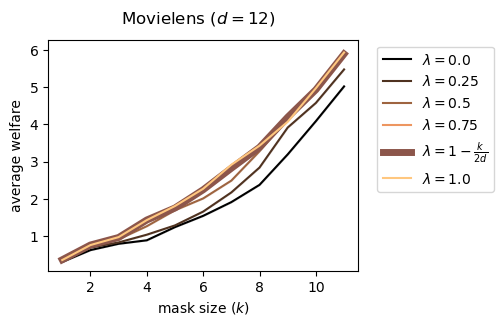

In [16]:
plt.figure(figsize=(4,3))
j = 0
for i, lam in enumerate(lam_list):
    lam_params = dict()
    if lam == '1-k/2d':
        lam_params['mean_learned'] = dict(color='tab:brown', linestyle='-', label=r'$\lambda=1-\frac{k}{2d}$', linewidth=5)
    else:
        lam_params['mean_learned'] = dict(color=cont_colors[j], linestyle='-', label=f'$\lambda={lam}$')
        j += 1
    plot(base_dct=per_lam[lam], 
         x_list=k_list, 
         lines=['mean_learned'],
         line_params=lam_params,
         metric='welfare', 
         xlabel=r'mask size ($k$)', 
         ylabel='average welfare', 
         title=r'Movielens ($d=12$)', 
         include_last=False,
         ylim_extra=(0, 0.17),
         plot_errors=False,
        )
plt.show()

# prices

## gamma

In [17]:
df = all_exp_df[(all_exp_df['d'] == 12) & 
                (all_exp_df['k'] == 6) & 
                (all_exp_df['proxy_lam_name'] == '1-k/2d') &
                (all_exp_df['V_eps'] == 0.0) & 
                (all_exp_df['p_eps'] == 0.0) & 
                (all_exp_df['rho'] == 0.0) &
                (~all_exp_df['gamma'].isin([0.01, 0.99]))
               ]
per_gamma = aggregate(df, 'gamma')
gamma_list = sorted(per_gamma.keys())

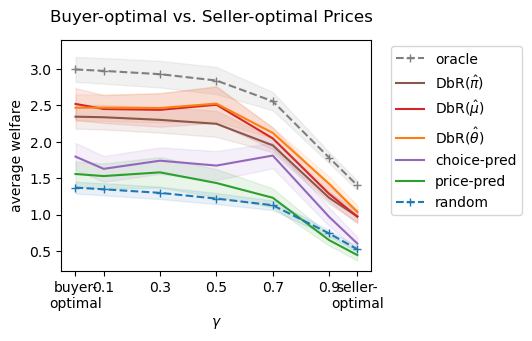

In [18]:
plt.figure(figsize=(4,3))
plot(base_dct=per_gamma, 
     x_list=gamma_list, 
     lines=lines,
     line_params=line_params,
     metric='welfare', 
     xlabel=r'$\gamma$', 
     ylabel='average welfare', 
     title='Buyer-optimal vs. Seller-optimal Prices',
     xticks=(gamma_list, ['buyer-\noptimal'] + gamma_list[1:-1] + ['seller-\noptimal']),
    )
plt.show()

## V_eps

In [19]:
df = all_exp_df[(all_exp_df['d'] == 12) & 
                (all_exp_df['k'] == 6) & 
                (all_exp_df['proxy_lam_name'] == '1-k/2d') &
                (all_exp_df['gamma'] == 0.5) & 
                (all_exp_df['p_eps'] == 0.0) & 
                (all_exp_df['rho'] == 0.0)
               ]
per_V_eps = aggregate(df, 'V_eps')
V_eps_list = sorted(per_V_eps.keys())

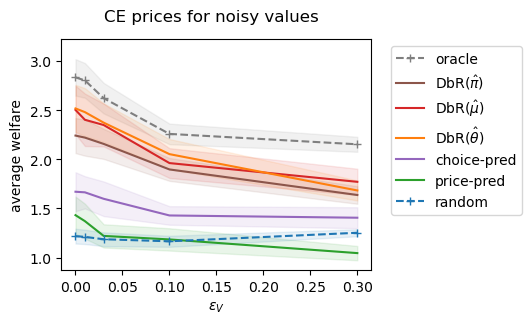

In [20]:
plt.figure(figsize=(4,3))
plot(base_dct=per_V_eps, 
     x_list=V_eps_list, 
     lines=lines,
     line_params=line_params,
     metric='welfare', 
     xlabel=r'$\epsilon_V$', 
     ylabel='average welfare', 
     title='CE prices for noisy values',
    )
plt.show()

## p_eps

In [21]:
df = all_exp_df[(all_exp_df['d'] == 12) & 
                (all_exp_df['k'] == 6) & 
                (all_exp_df['proxy_lam_name'] == '1-k/2d') &
                (all_exp_df['gamma'] == 0.5) & 
                (all_exp_df['V_eps'] == 0.0) & 
                (all_exp_df['rho'] == 0.0)
               ]
per_p_eps = aggregate(df, 'p_eps')
p_eps_list = sorted(per_p_eps.keys())

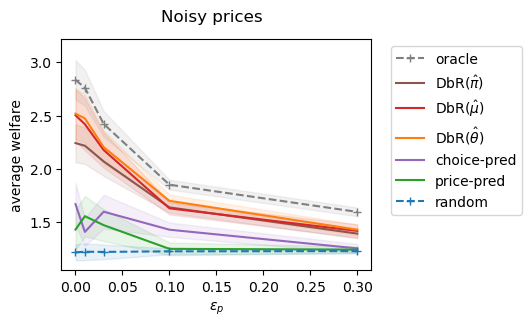

In [22]:
plt.figure(figsize=(4,3))
plot(base_dct=per_p_eps, 
     x_list=p_eps_list, 
     lines=lines,
     line_params=line_params,
     metric='welfare', 
     xlabel=r'$\epsilon_p$', 
     ylabel='average welfare', 
     title='Noisy prices',
    )
plt.show()

## rho

In [23]:
df = all_exp_df[(all_exp_df['d'] == 12) & 
                (all_exp_df['k'] == 6) & 
                (all_exp_df['proxy_lam_name'] == '1-k/2d') &
                (all_exp_df['V_eps'] == 0.0) & 
                (all_exp_df['p_eps'] == 0.0) & 
                (all_exp_df['gamma'] == 0.5)
               ]
per_rho = aggregate(df, 'rho')
rho_list = sorted(per_rho.keys())

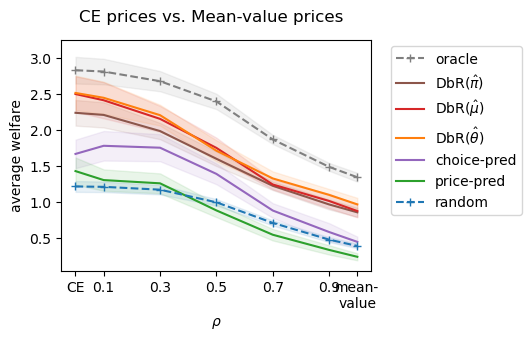

In [24]:
plt.figure(figsize=(4,3))
plot(base_dct=per_rho, 
     x_list=rho_list, 
     lines=lines,
     line_params=line_params,
     metric='welfare', 
     xlabel=r'$\rho$', 
     ylabel='average welfare', 
     title='CE prices vs. Mean-value prices',
     xticks=(rho_list, ['CE'] + rho_list[1:-1] + ['mean-\nvalue']),
    )
plt.show()

# d=100

In [25]:
df = all_exp_df[(all_exp_df['d'] == 100) & 
                (all_exp_df['gamma'] == 0.5) & 
                (all_exp_df['V_eps'] == 0.0) & 
                (all_exp_df['p_eps'] == 0.0) & 
                (all_exp_df['rho'] == 0.0) &
                (all_exp_df['proxy_lam_name'] == '0.5')
               ]

per_k = aggregate(df, 'k')
k_list = sorted(per_k.keys())
per_k_norm_b = {}
for k in k_list:
    per_k_norm_b[k] = dct_normalize(per_k[k], min_method='random', max_method=None)

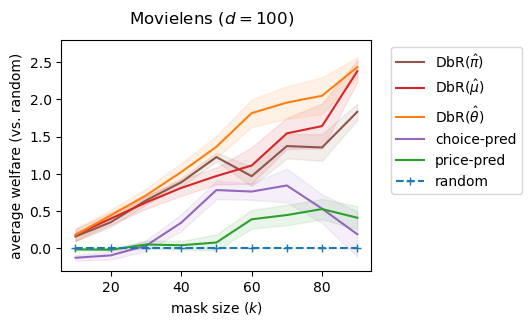

In [26]:
plt.figure(figsize=(4,3))
plot(base_dct=per_k_norm_b, 
     x_list=k_list, 
     lines=[line for line in lines if line != 'welfare_opt'],
     line_params=line_params,
     metric='welfare',      
     xlabel=r'mask size ($k$)', 
     ylabel='average welfare (vs. random)', 
     title=r'Movielens ($d=100$)', 
    )
plt.show()

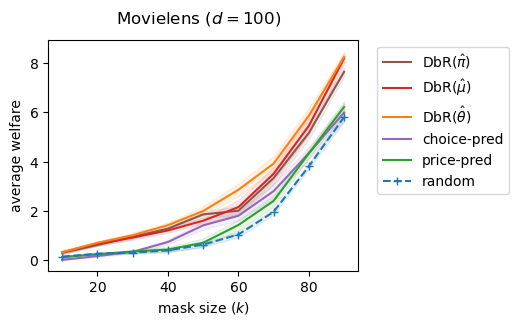

In [27]:
plt.figure(figsize=(4,3))
plot(base_dct=per_k, 
     x_list=k_list, 
     lines=[line for line in lines if line != 'welfare_opt'],
     line_params=line_params,
     metric='welfare', 
     xlabel=r'mask size ($k$)', 
     ylabel='average welfare', 
     title=r'Movielens ($d=100$)', 
    )
plt.show()